In [1]:
import os
import pandas as pd
import matplotlib
import math
from matplotlib import pyplot as plt
from matplotlib import figure
%matplotlib inline

font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)


__location__ = os.path.realpath((os.getcwd()))

raw_data = pd.read_csv(os.path.join(__location__, 'data/cleaned_data.csv'))
raw_data['date_time']  = pd.to_datetime(raw_data['date_time'])

user_messages = raw_data[raw_data['user']!='WhatsApp']
notifications = raw_data[raw_data['user']=='WhatsApp']

print 'loaded',len(user_messages),'user messages and',len(notifications),'WhatsApp notifications from file'

user_names = set(user_messages['user'])
min_day = raw_data['date_time'].min()
max_day = raw_data['date_time'].max()

print raw_data

loaded 19974 user messages and 136 WhatsApp notifications from file
                date_time                                            message  \
0     2013-09-28 17:29:00          Shaggy changed the subject to “The hoard”   
1     2013-09-28 17:29:00                              USER_ENTERED : Shaggy   
2     2013-09-28 17:29:00                               USER_ENTERED : Marth   
3     2013-09-28 17:29:00                                USER_ENTERED : Dave   
4     2013-09-28 17:30:00                                           [MEDIA]    
5     2013-09-28 17:33:00                                USER_ENTERED : Bunn   
6     2013-09-28 17:33:00                                USER_ENTERED : Cate   
7     2013-09-28 17:33:00                                USER_ENTERED : Phil   
8     2013-09-28 17:31:00                                           [MEDIA]    
9     2013-09-28 17:33:00                   Shaggy changed this group's icon   
10    2013-09-28 17:51:00                           

split messages and write to files for ease of access.

In [2]:
import nltk 
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import os
import string
import re

stop_words = {'im','a','able','about','across','after','all','almost','also','am','among','an','and','any','are','as','at','be','because','been','but','by','can','cannot','could','dear','did','do','does','either','else','ever','every','for','from','get','got','had','has','have','he','her','hers','him','his','how','however','i','if','in','into','is','it','its','just','least','let','like','likely','may','me','might','most','must','my','neither','no','nor','not','of','off','often','on','only','or','other','our','own','rather','said','say','says','she','should','since','so','some','than','that','the','their','them','then','there','these','they','this','tis','to','too','twas','us','wants','was','we','were','what','when','where','which','while','who','whom','why','will','with','would','yet','you','your'}
exclude = set(string.punctuation)
exclude.remove('\'')

token_dict = {}
stemmer = PorterStemmer()

def replace_punctiation_char(ch):
    if ch in exclude:
        return ' '
    else :
        return ch
    
def convert_utf(in_):
    try :
        return str(in_)
    except UnicodeEncodeError:
        return str(in_.encode('ascii', 'ignore'))
  
def remove_websites(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)      

def remove_punctiation(s):    
    return ''.join(replace_punctiation_char(ch) for ch in s )
    
def remove_emojis(s):
    return re.sub(r'EMOJI\[[a-z\d]*\]', ' ', s)

def remove_media(s):
    return re.sub(r'MEDIA', ' ', s)

def replace_repeats(s):
    return re.sub(r'(.)\1{3,}', r'\1', s)
    
def stem_tokens(tokens, stemmer):
    stemmed = [stemmer.stem(item) for item in tokens]
    return ' '.join(stemmed)

def remove_whitespace(s):
    return ' '.join(s.split())

def remove_numbers(s):
    return re.sub("\d+", "", s)

def scrub_text(text):
    #text =  fin.read().strip() # Prints the content of the file
    just_text = convert_utf(remove_websites(remove_media(remove_emojis(text)).lower()))
    no_punctuation = remove_numbers(remove_punctiation(just_text))
    no_repeats = replace_repeats(no_punctuation)
    return remove_whitespace(no_repeats) 

def concatenate_list(input_strings):
    return reduce(lambda x,y : x + "." + y,input_strings)

user_messages['scrubbed_text'] = [scrub_text(text) for text in user_messages.message]
print user_messages

def get_messages(user_name):    
    this_user_messages = user_messages[user_messages['user']==user_name]
    return concatenate_list(this_user_messages.scrubbed_text.values)

def write_messages(messages, user_name):
    output_file = open(os.path.join(__location__, 'nlp/user_messages/' + user_name + '.txt'),'w')
    output_file.write(messages)
    output_file.close()
    
for user_name in user_names:
    messages = get_messages(user_name)
    write_messages(messages, user_name) 

                date_time                                            message  \
4     2013-09-28 17:30:00                                           [MEDIA]    
8     2013-09-28 17:31:00                                           [MEDIA]    
10    2013-09-28 17:51:00                                [MEDIA] .  [MEDIA]    
11    2013-09-28 17:53:00                                           [MEDIA]    
12    2013-09-28 17:53:00                                           [MEDIA]    
13    2013-09-28 17:55:00                                       Add vanessa!   
14    2013-09-28 18:51:00                                           [MEDIA]    
15    2013-09-28 20:13:00  With the help of Tegs, Angie and Gee xx.  [MED...   
16    2013-09-28 20:15:00                                           [MEDIA]    
17    2013-09-28 20:40:00                                OMG I'm so excited!   
18    2013-09-28 21:00:00                           Desde mexico!.  [MEDIA]    
19    2013-09-28 21:01:00               

/home/mikesj/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
corpusdir= 'nlp/user_messages/'
newcorpus = PlaintextCorpusReader(corpusdir, '.*')

def tokenize(text):
    #text =  fin.read().strip() # Prints the content of the file
    just_text = remove_websites(remove_media(remove_emojis(text)).lower())
    no_punctuation = remove_punctiation(just_text)
    no_repeats = replace_repeats(no_punctuation)
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems  

def remove_whitespace(s):
    return ' '.join(s.split())
    
for infile in sorted(newcorpus.fileids()):
    #print infile # The fileids of each file.
    fin =  newcorpus.open(infile)  # Opens the file.
    text =  fin.read().strip() # Prints the content of the file
    token_dict[infile] = convert_utf(text)


In [5]:
# import numpy as np
    
# tvf = TfidfVectorizer(min_df=3,  max_features=None, strip_accents='unicode',  
#         analyzer='word',token_pattern=r'\w{1,}',ngram_range=(0,1), use_idf=1,smooth_idf=1,
#         sublinear_tf=1, stop_words = 'english')

# for key in token_dict.keys():
#     tvf.fit(get_other_docs(key))
#     feature_names = tvf.get_feature_names()
#     tfidf_array = tvf.transform([token_dict[key]])
#     scores = np.ravel(tfidf_array.todense())
#     with_index = zip(feature_names, scores)

    

In [6]:
user_messages['month_name'] = [date.strftime('%b-%Y') for date in user_messages.date_time]

/home/mikesj/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [7]:
def concatenate_documents(group):
    return '.'.join(group.scrubbed_text)

month_docs = user_messages.groupby('month_name').apply(concatenate_documents)

In [8]:
from itertools import groupby

def find_subset_words(words):
    single_words = set()
    double_words = set()
    return_words = []
    for word in words:
        word_split = word.split()
        if(len(word_split) == 1):
            single_words.update(word_split)
        else:
            double_words.update(word_split)
            return_words.append(word)
    def is_subset_word(single):
        for double in double_words:
            return single in double
                
    return [single for single in single_words if not is_subset_word(single)] + return_words

print find_subset_words(['a','c', 'a b','a d'])

['c', 'a b', 'a d']


In [24]:
import pyximport
pyximport.install()
from wordcloud.wordcloud import WordCloud
    
tvf = TfidfVectorizer(min_df=2,  max_features=None, strip_accents='unicode',  
    analyzer='word', #token_pattern=r'\w{1,}',
    ngram_range=(0,2), use_idf=1,smooth_idf=1,
    sublinear_tf=1, stop_words = 'english')

#tvf = CountVectorizer(min_df=2,  max_features=None, strip_accents='unicode',  
#    analyzer='word',token_pattern=r'\w{1,}',ngram_range=(0,2), stop_words = 'english')

WIDTH = 800
HEIGHT = 400

wc = WordCloud(background_color="white", 
               max_words=2000, 
               width= WIDTH, 
               height = HEIGHT,
               font_path = '/usr/share/fonts/truetype/ttf-dejavu/DejaVuSansMono.ttf'
              )

print wc.font_path

tvf.fit(month_docs)

sorted_dates = sorted(month_docs.index.values)

/usr/share/fonts/truetype/ttf-dejavu/DejaVuSansMono.ttf


Apr-2014
Apr-2015
Aug-2014
Aug-2015
Dec-2013
Dec-2014
Feb-2014
Feb-2015
Jan-2014
Jan-2015
Jul-2014
Jul-2015
Jun-2014
Jun-2015
Mar-2014
Mar-2015
May-2014
May-2015
Nov-2013
Nov-2014
Oct-2013
Oct-2014
Sep-2013
Sep-2014
Sep-2015


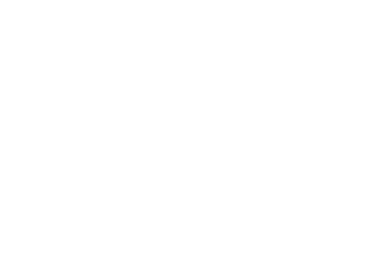

In [16]:
for month in sorted_dates:
    print month
    feature_names = tvf.get_feature_names()
    tfidf_array = tvf.transform([month_docs[month]])
    scores = np.ravel(tfidf_array.todense())
    with_index = zip(feature_names, scores)
    words = sorted(with_index , key = lambda pair : - pair[1])
    #print words
    wc.generate_from_word_sizes(words)
    wc.to_file('wordcloud/months/' + month + '.png')
    plt.axis("off")

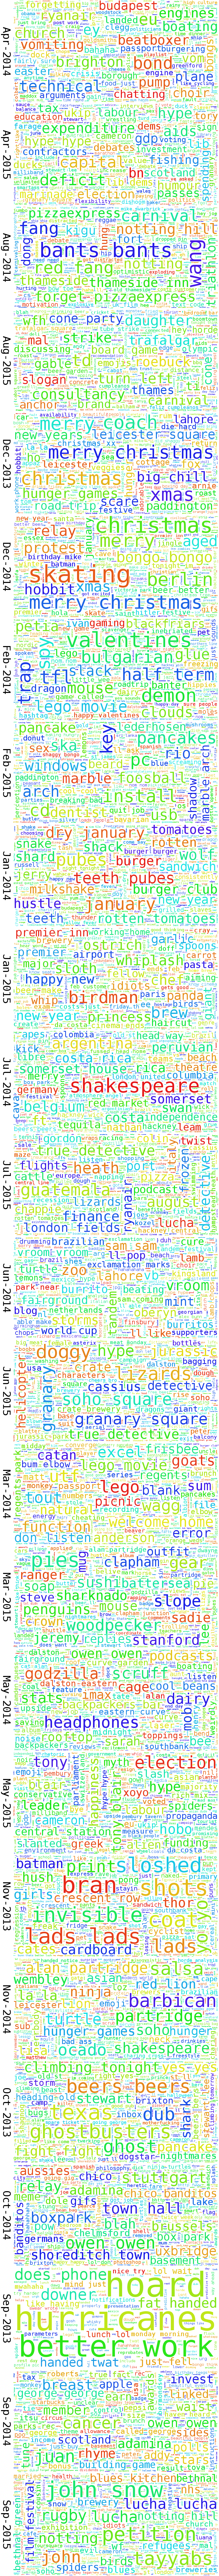

In [24]:
def image_from_text(text):
    return

import PIL
from PIL import ImageFont
from PIL import Image as image
from PIL import ImageDraw

def make_text_image(text):
    font = ImageFont.truetype("/usr/share/fonts/truetype/ttf-dejavu/DejaVuSansMono.ttf", 40)
    img=Image.new("RGBA", (HEIGHT,50),(255,255,255))
    draw = ImageDraw.Draw(img)
    w, h = font.getsize(text)
    draw.text(((HEIGHT-w)/2,0), text, fill="black", font = font)
    out = img.rotate(270)
    out.save('wordcloud/months/text_image_' + text + '.png')
    return out
from IPython.display import Image as ipImage

from matplotlib.pyplot import imshow

concat_im = Image.new('RGB', (WIDTH + 50, HEIGHT * len(sorted_dates)))

for index, month in enumerate(sorted_dates):
    im = image.open("wordcloud/months/" + month + '.png')
    text_im = make_text_image(month)
    concat_im.paste(im, (50, HEIGHT * index))
    concat_im.paste(text_im,(0, HEIGHT * index))
big_file_name = 'wordcloud/months/big_file.png'
concat_im.save(big_file_name)

ipImage(big_file_name)

In [20]:
Image.open('/home/mikesj/Documents/Horde_Analysis/wordcloud/months/Apr-2014.png')

IOError: cannot identify image file '/home/mikesj/Documents/Horde_Analysis/wordcloud/months/Apr-2014.png'

In [68]:
stop_words.update(["b", "wop","✌", "pm", "x", "p", "kx", "it's", "should've"])

In [69]:
def beta_log_power(x):
    if x == 0:
        return 0
    else:
        return (x-0.5) * np.log(x)
def log_beta_approx(x,y):

    return np.log(np.sqrt(2 * np.pi)) + beta_log_power(x) + beta_log_power(y) - beta_log_power(x + y)
import numpy as np
from scipy.special import beta, digamma

def surprise(prior_N, prior_n, post_N, post_n):
    if prior_n == 0:
        return 0
    a , b = prior_n, prior_N - prior_n 
    a_, b_ = a + post_n, b + post_N - post_n  
    return (log_beta_approx(a,b) - log_beta_approx(a_, b_) - \
        post_n * (digamma(a + b + post_N) - digamma(a + post_n)) - \
        (post_N - post_n) * (digamma(a + b + post_N) - digamma(b + post_N - post_n)) ) / np.log(2)

In [70]:
# this code tries to find the baseline rate of the word (we remove the most extreme user, and the user we are looking at)
def get_surprises_from_word(word, user_map, total_map, user_totals, total_words):
    scores = {}
    max_user = user_names[np.argmax([user_map[user][word] * 1. / user_totals[user] for user in user_names])]
    for user in user_names:
        user_counter = user_map[user]
        post_N = user_totals[user]
        prior_N = total_words - post_N
        if user != max_user:
            prior_N -= user_totals[max_user]
            pass
        
        post_n = user_counter[word]
        prior_n = total_map[word] - post_n
        if user != max_user:
            prior_n -= user_map[max_user][word]
            pass
        #print prior_n, prior_N, post_n, post_N
        if prior_n * 1. / prior_N > post_n * 1. / post_N:
            scores[user] = surprise(prior_N, prior_n, post_N, post_n) / 100
        else:
            scores[user] = surprise(prior_N, prior_n, post_N, post_n)
    return scores

In [97]:
import operator
from collections import defaultdict

def is_ascii(word):
    try:
        word.encode("ascii")
        return True
    except:
        return False

def get_user_scores(user_map, total_map):
    print 'getting scores'
    sorted_total = sorted(total_map.items(), key = operator.itemgetter(1))
    sorted_total.reverse()
    keep_words = set([x[0] for x in sorted_total[:20000]])
    
    user_totals = {}
    for user in user_names:
        user_totals[user] = sum(user_map[user].values())
    total_words = sum(total_map.values())

    user_scores = defaultdict(list)
    
    count = 0
    for word in list(keep_words):
        if word in stop_words or not is_ascii(word):
            continue
        count += 1
        word_scores = get_surprises_from_word(word, user_map, total_map, user_totals, total_words)
        for user in user_names:
            if user_map[user][word] > 0:
                score = word_scores[user]
                user_scores[user].append((word, score))
            
    for user in user_names:
        scores = sorted(user_scores[user], key= operator.itemgetter(1))
        scores.reverse()
        user_scores[user] = scores
    return user_scores


In [84]:
user_messages.columns
user_messages['date'] = [d.strftime("%Y-%m-%d") for d in user_messages.date_time]

/home/mikesj/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [85]:
gp_user_date = user_messages.groupby(["user",'date'])["scrubbed_text"].apply(lambda x : ".".join(x)).copy().reset_index()
gp_user_date.columns

Index([u'user', u'date', u'scrubbed_text'], dtype='object')

In [86]:
gp_user_date['word_set'] = [set(s.replace(".", " ").split()) for s in gp_user_date.scrubbed_text]

In [87]:
user_messages['word_set'] = [set(s.replace(".", " ").split()) for s in user_messages.scrubbed_text]

/home/mikesj/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [88]:
def collect_counter(l):
    counter = Counter()
    for s in l:
        counter.update(s)
    return [counter]

user_counters = user_messages.groupby(['user'])['word_set'].apply(collect_counter).reset_index()

In [89]:
user_map = {}
for dict_ in user_counters.to_dict(orient = 'records'):
    user = dict_['user']
    word_set = dict_['word_set'][0]
    user_map[user] = word_set

In [90]:
total_map= Counter()
for counter in user_map.values():
    total_map.update(counter)


In [91]:
user_names = list(user_names)

In [92]:
user_scores = get_user_scores(user_map, total_map)

getting scores


In [93]:
RADIUS = 400
circle = np.zeros((2 * RADIUS, 2 * RADIUS))
circle.shape
count = 0
for i in range(2* RADIUS):
    for j in range(2 * RADIUS):
        x = i - RADIUS
        y = j - RADIUS
        if x*x + y*y > RADIUS * RADIUS:
            circle[i,j]=1
            count += 1


WIDTH = 2 * RADIUS
HEIGHT = 2* RADIUS


wc = WordCloud(font_path = '/usr/share/fonts/truetype/ttf-dejavu/DejaVuSansMono.ttf',
               background_color="white",
               max_words=200,
               width= WIDTH, 
               height = HEIGHT, 
               mask = circle,
               prefer_horizontal = 0.9)

In [94]:
def make_wordcloud(user, user_score, adjust = 1):
    print 'making word clouds : '
    file_text =  user + '_' + str(adjust)
    
    volume_scale = max([math.sqrt(scores[0][1]) for scores in user_scores.values()])
    volume_scale *= adjust * 800. / WIDTH

    print user,
    scores = user_scores[user]
    scaled_scores = [(pair[0], math.sqrt(pair[1]) / volume_scale) for pair in scores]

    wc.generate_from_word_sizes(scaled_scores)
    wc.to_file('wordcloud/user_imgs/' + file_text + '.png')
    plt.axis("off")   
    
for user in user_names:
    try:
        make_wordcloud(user, user_scores, adjust = 1)
    except:
        print "failed on user " , user

making word clouds : 
failed on user  Pete
making word clouds : 
failed on user  Wagg
making word clouds : 
failed on user  Cate
making word clouds : 
failed on user  Eliza
making word clouds : 
failed on user  Angela
making word clouds : 
failed on user  Bunn
making word clouds : 
failed on user  Tanya
making word clouds : 
failed on user  Loz
making word clouds : 
failed on user  Lora
making word clouds : 
failed on user  Mike
making word clouds : 
failed on user  Simone
making word clouds : 
failed on user  Vanessa
making word clouds : 
failed on user  Catrin
making word clouds : 
failed on user  Dan
making word clouds : 
failed on user  Jimena
making word clouds : 
failed on user  Alan
making word clouds : 
failed on user  Dave
making word clouds : 
failed on user  Joe
making word clouds : 
failed on user  Vinay
making word clouds : 
failed on user  Wills
making word clouds : 
failed on user  Krizia
making word clouds : 
failed on user  Shaggy
making word clouds : 
failed on user  

In [ ]:
for word, score in user_scores["Mal"][:10]:
    print is_ascii(str(word)) 

In [ ]:
s = "✌"

In [96]:
user_map['Mike']['the']

412